# Regression Week 3: Assessing Fit (polynomial regression)

# Fire up Turi Create

In [1]:
import turicreate

Next we're going to write a polynomial function that takes an SArray and a maximal degree and returns an SFrame with columns containing the SArray to all the powers up to the maximal degree.

The easiest way to apply a power to an SArray is to use the .apply() and lambda x: functions. 
For example to take the example array and compute the third power we can do as follows: (note running this cell the first time may take longer than expected since it loads Turi Create)

In [2]:
tmp = turicreate.SArray([1., 2., 3.])
tmp_cubed = tmp.apply(lambda x: x**3)
print (tmp)
print (tmp_cubed)

Using default 16 lambda workers.

To maximize the degree of parallelism, add the following code to the beginning of the program:

"turicreate.config.set_runtime_config('TURI_DEFAULT_NUM_PYLAMBDA_WORKERS', 32)"

Note that increasing the degree of parallelism also increases the memory footprint.

[1.0, 2.0, 3.0]
[1.0, 8.0, 27.0]


We can create an empty SFrame using turicreate.SFrame() and then add any columns to it with ex_sframe['column_name'] = value. For example we create an empty SFrame and make the column 'power_1' to be the first power of tmp (i.e. tmp itself).

In [3]:
ex_sframe = turicreate.SFrame()
ex_sframe['power_1'] = tmp
print (ex_sframe)

+---------+
| power_1 |
+---------+
|   1.0   |
|   2.0   |
|   3.0   |
+---------+
[3 rows x 1 columns]



# Polynomial_sframe function

Using the hints above complete the following function to create an SFrame consisting of the powers of an SArray up to a specific degree:

In [4]:
def polynomial_sframe(feature, degree):
    # assume that degree >= 1
    # initialize the SFrame:
    poly_sframe = turicreate.SFrame()
    # and set poly_sframe['power_1'] equal to the passed feature
    poly_sframe['power_1'] =feature 
    # first check if degree > 1
    if degree > 1:
        # then loop over the remaining degrees:
        # range usually starts at 0 and stops at the endpoint-1. We want it to start at 2 and stop at degree
        for power in range(2, degree+1): 
            # first we'll give the column a name:
            name = 'power_' + str(power)
            # then assign poly_sframe[name] to the appropriate power of feature
            poly_sframe[name] = feature.apply(lambda x: x**power)
    return poly_sframe

To test your function consider the smaller tmp variable and what you would expect the outcome of the following call:

In [7]:
print (polynomial_sframe(tmp, 3))

+---------+---------+---------+
| power_1 | power_2 | power_3 |
+---------+---------+---------+
|   1.0   |   1.0   |   1.0   |
|   2.0   |   4.0   |   8.0   |
|   3.0   |   9.0   |   27.0  |
+---------+---------+---------+
[3 rows x 3 columns]



# Visualizing polynomial regression

Let's use matplotlib to visualize what a polynomial regression looks like on some real data.

In [12]:
sales = turicreate.SFrame('../Week 2/home_data.sframe/')

As in Week 3, we will use the sqft_living variable. For plotting purposes (connecting the dots), you'll need to sort by the values of sqft_living. For houses with identical square footage, we break the tie by their prices.

In [13]:
sales = sales.sort(['sqft_living', 'price'])

Let's start with a degree 1 polynomial using 'sqft_living' (i.e. a line) to predict 'price' and plot what it looks like.

In [14]:
poly1_data = polynomial_sframe(sales['sqft_living'], 1)
poly1_data['price'] = sales['price'] # add price to the data since it's the target

NOTE: for all the models in this notebook use validation_set = None to ensure that all results are consistent across users.

In [15]:
model1 = turicreate.linear_regression.create(poly1_data, target = 'price', features = ['power_1'], validation_set = None)

Linear regression:

--------------------------------------------------------

Number of examples          : 21613

Number of features          : 1

Number of unpacked features : 1

Number of coefficients    : 2

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------------------------+

| Iteration | Passes   | Elapsed Time | Training Max Error | Training Root-Mean-Square Error |

+-----------+----------+--------------+--------------------+---------------------------------+

| 1         | 2        | 1.351428     | 4362074.696077     | 261440.790724                   |

+-----------+----------+--------------+--------------------+---------------------------------+

SUCCESS: Optimal solution found.

In [16]:
#let's take a look at the weights before we plot
model1.coefficients

name,index,value,stderr
(intercept),None,-43579.08525144879,4402.689697427721
power_1,None,280.62277088584665,1.9363985551321239


In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

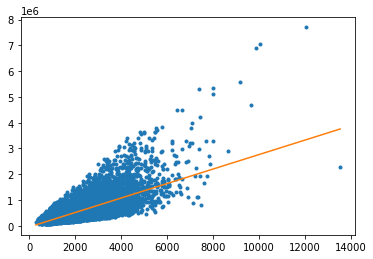

In [18]:
plt.plot(poly1_data['power_1'],poly1_data['price'],'.',
         poly1_data['power_1'], model1.predict(poly1_data),'-')

Let's unpack that plt.plot() command. The first pair of SArrays we passed are the 1st power of sqft and the actual price we then ask it to print these as dots '.'. The next pair we pass is the 1st power of sqft and the predicted values from the linear model. We ask these to be plotted as a line '-'. 

We can see, not surprisingly, that the predicted values all fall on a line, specifically the one with slope 280 and intercept -43579. What if we wanted to plot a second degree polynomial?

In [22]:
poly2_data = polynomial_sframe(sales['sqft_living'], 2)
my_features = poly2_data.column_names() # get the name of the features
print (my_features)
poly2_data['price'] = sales['price'] # add price to the data since it's the target
model2 = turicreate.linear_regression.create(poly2_data, target = 'price', features = my_features, validation_set = None)

['power_1', 'power_2']


In [20]:
model2.coefficients

name,index,value,stderr
(intercept),None,199222.496444621,7058.004835516223
power_1,None,67.99406406773825,5.287872013161707
power_2,None,0.03858123127891564,0.0008982465470323339


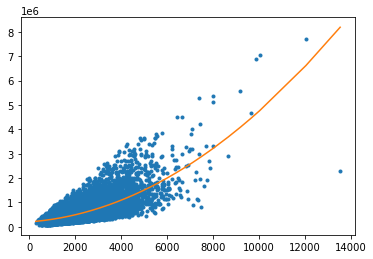

In [21]:
plt.plot(poly2_data['power_1'],poly2_data['price'],'.',
         poly2_data['power_1'], model2.predict(poly2_data),'-')

The resulting model looks like half a parabola. Try on your own to see what the cubic looks like:

In [23]:
poly3_data = polynomial_sframe(sales['sqft_living'], 3)
my_features = poly3_data.column_names() # get the name of the features
print (my_features)
poly3_data['price'] = sales['price'] # add price to the data since it's the target
model3 = turicreate.linear_regression.create(poly3_data, target = 'price', features = my_features, validation_set = None)

['power_1', 'power_2', 'power_3']


Linear regression:

--------------------------------------------------------

Number of examples          : 21613

Number of features          : 3

Number of unpacked features : 3

Number of coefficients    : 4

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------------------------+

| Iteration | Passes   | Elapsed Time | Training Max Error | Training Root-Mean-Square Error |

+-----------+----------+--------------+--------------------+---------------------------------+

| 1         | 2        | 0.761303     | 3261066.736008     | 249261.286346                   |

+-----------+----------+--------------+--------------------+---------------------------------+

SUCCESS: Optimal solution found.

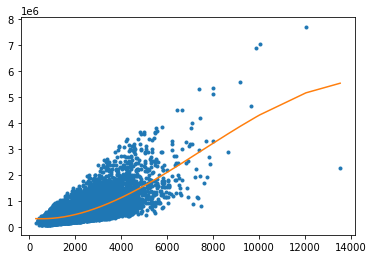

In [24]:
plt.plot(poly3_data['power_1'],poly3_data['price'],'.',
         poly3_data['power_1'], model3.predict(poly3_data),'-')

Now try a 15th degree polynomial:

In [25]:
poly15_data = polynomial_sframe(sales['sqft_living'], 15)
my_features = poly15_data.column_names() # get the name of the features
print (my_features)
poly15_data['price'] = sales['price'] # add price to the data since it's the target
model15 = turicreate.linear_regression.create(poly15_data, target = 'price', features = my_features, validation_set = None)

['power_1', 'power_2', 'power_3', 'power_4', 'power_5', 'power_6', 'power_7', 'power_8', 'power_9', 'power_10', 'power_11', 'power_12', 'power_13', 'power_14', 'power_15']


Linear regression:

--------------------------------------------------------

Number of examples          : 21613

Number of features          : 15

Number of unpacked features : 15

Number of coefficients    : 16

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------------------------+

| Iteration | Passes   | Elapsed Time | Training Max Error | Training Root-Mean-Square Error |

+-----------+----------+--------------+--------------------+---------------------------------+

| 1         | 2        | 0.394166     | 2662308.584341     | 245690.511190                   |

+-----------+----------+--------------+--------------------+---------------------------------+

SUCCESS: Optimal solution found.

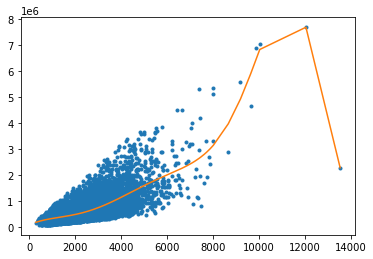

In [27]:
plt.plot(poly15_data['power_1'],poly15_data['price'],'.',
         poly15_data['power_1'], model15.predict(poly15_data),'-')

What do you think of the 15th degree polynomial? Do you think this is appropriate? If we were to change the data do you think you'd get pretty much the same curve? Let's take a look.

# Changing the data and re-learning

We're going to split the sales data into four subsets of roughly equal size. Then you will estimate a 15th degree polynomial model on all four subsets of the data. Print the coefficients (you should use .print_rows(num_rows = 16) to view all of them) and plot the resulting fit (as we did above). The quiz will ask you some questions about these results.

To split the sales data into four subsets, we perform the following steps:
* First split sales into 2 subsets with `.random_split(0.5, seed=0)`. 
* Next split the resulting subsets into 2 more subsets each. Use `.random_split(0.5, seed=0)`.

We set `seed=0` in these steps so that different users get consistent results.
You should end up with 4 subsets (`set_1`, `set_2`, `set_3`, `set_4`) of approximately equal size. 

In [28]:
set_1,set_3=sales.random_split(0.5, seed=0)
set_1,set_2=set_1.random_split(0.5, seed=0)
set_3,set_4=set_3.random_split(0.5, seed=0)

Fit a 15th degree polynomial on set_1, set_2, set_3, and set_4 using sqft_living to predict prices. Print the coefficients and make a plot of the resulting model.

['power_1', 'power_2', 'power_3', 'power_4', 'power_5', 'power_6', 'power_7', 'power_8', 'power_9', 'power_10', 'power_11', 'power_12', 'power_13', 'power_14', 'power_15']


Linear regression:

--------------------------------------------------------

Number of examples          : 5404

Number of features          : 15

Number of unpacked features : 15

Number of coefficients    : 16

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------------------------+

| Iteration | Passes   | Elapsed Time | Training Max Error | Training Root-Mean-Square Error |

+-----------+----------+--------------+--------------------+---------------------------------+

| 1         | 2        | 0.561864     | 2195218.932304     | 248858.822200                   |

+-----------+----------+--------------+--------------------+---------------------------------+

SUCCESS: Optimal solution found.

+-------------+-------+-------------------------+------------------------+
|     name    | index |          value          |         stderr         |
+-------------+-------+-------------------------+------------------------+
| (intercept) |  None |    223312.75024654047   |   884262.3985967207    |
|   power_1   |  None |    118.08612759234558   |   3852.0598663547903   |
|   power_2   |  None |  -0.047348201138194934  |    6.93193555959046    |
|   power_3   |  None |  3.2531034248124225e-05 |  0.006802098131297505  |
|   power_4   |  None |  -3.323721525786276e-09 |  4.04848915474522e-06  |
|   power_5   |  None |  -9.758304576993627e-14 | 1.5379815360975301e-09 |
|   power_6   |  None |  1.1544030342316536e-17 | 3.842513484771583e-13  |
|   power_7   |  None |  1.0514586941755864e-21 | 6.617268169308977e-17  |
|   power_8   |  None |  3.460496165182913e-26  | 8.881539062993691e-21  |
|   power_9   |  None | -1.0965445415372115e-30 | 9.903595471989573e-25  |
|   power_10  |  None | -

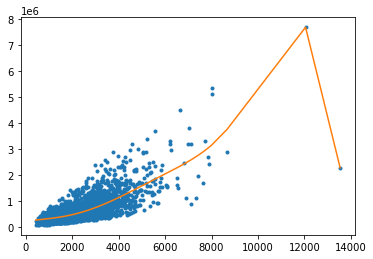

In [36]:
poly15_set_1 = polynomial_sframe(set_1['sqft_living'], 15)
my_features = poly15_set_1.column_names() # get the name of the features
print (my_features)
poly15_set_1['price'] = set_1['price'] # add price to the data since it's the target
model15 = turicreate.linear_regression.create(poly15_set_1, target = 'price', features = my_features, validation_set = None)
model15.coefficients.print_rows(num_rows = 16)
plt.plot(poly15_set_1['power_1'],poly15_set_1['price'],'.',
         poly15_set_1['power_1'], model15.predict(poly15_set_1),'-')

['power_1', 'power_2', 'power_3', 'power_4', 'power_5', 'power_6', 'power_7', 'power_8', 'power_9', 'power_10', 'power_11', 'power_12', 'power_13', 'power_14', 'power_15']


Linear regression:

--------------------------------------------------------

Number of examples          : 5398

Number of features          : 15

Number of unpacked features : 15

Number of coefficients    : 16

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------------------------+

| Iteration | Passes   | Elapsed Time | Training Max Error | Training Root-Mean-Square Error |

+-----------+----------+--------------+--------------------+---------------------------------+

| 1         | 2        | 0.468452     | 2069212.978547     | 234840.067186                   |

+-----------+----------+--------------+--------------------+---------------------------------+

SUCCESS: Optimal solution found.

+-------------+-------+-------------------------+------------------------+
|     name    | index |          value          |         stderr         |
+-------------+-------+-------------------------+------------------------+
| (intercept) |  None |    89836.50773618126    |   2037858.9296177367   |
|   power_1   |  None |    319.80694675714324   |   12174.023314411474   |
|   power_2   |  None |   -0.10331539703719657  |   30.564072551776334   |
|   power_3   |  None |  1.066824760617431e-05  |  0.04275370723927532   |
|   power_4   |  None |  5.7557709769722895e-09 | 3.725164693102124e-05  |
|   power_5   |  None | -2.5466346469331415e-13 | 2.1372068365340047e-08 |
|   power_6   |  None | -1.0964134506311831e-16 | 8.301549719966323e-12  |
|   power_7   |  None |  -6.364584417136837e-21 | 2.2073089320893184e-15 |
|   power_8   |  None |  5.525604168178261e-25  | 4.030743323165638e-19  |
|   power_9   |  None |  1.3508203896990332e-28 | 5.1093485377981744e-23 |
|   power_10  |  None |  

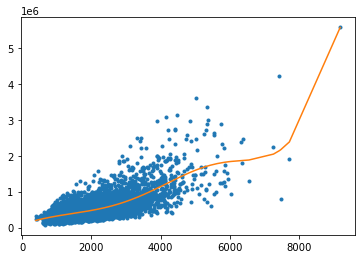

In [37]:
poly15_set_2 = polynomial_sframe(set_2['sqft_living'], 15)
my_features = poly15_set_2.column_names() # get the name of the features
print (my_features)
poly15_set_2['price'] = set_2['price'] # add price to the data since it's the target
model15 = turicreate.linear_regression.create(poly15_set_2, target = 'price', features = my_features, validation_set = None)
model15.coefficients.print_rows(num_rows = 16)
plt.plot(poly15_set_2['power_1'],poly15_set_2['price'],'.',
         poly15_set_2['power_1'], model15.predict(poly15_set_2),'-')

Some questions you will be asked on your quiz:

**Quiz Question: Is the sign (positive or negative) for power_15 the same in all four models?**

**Quiz Question: (True/False) the plotted fitted lines look the same in all four plots**

# Selecting a Polynomial Degree

Whenever we have a "magic" parameter like the degree of the polynomial there is one well-known way to select these parameters: validation set. (We will explore another approach in week 4).

We split the sales dataset 3-way into training set, test set, and validation set as follows:

* Split our sales data into 2 sets: `training_and_validation` and `testing`. Use `random_split(0.9, seed=1)`.
* Further split our training data into two sets: `training` and `validation`. Use `random_split(0.5, seed=1)`.

Again, we set `seed=1` to obtain consistent results for different users.

In [38]:
training_and_validation,testing=sales.random_split(0.9, seed=1)
training,validation=training_and_validation.random_split(0.5, seed=1)

Next you should write a loop that does the following:
* For degree in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15] (to get this in python type range(1, 15+1))
    * Build an SFrame of polynomial data of train_data['sqft_living'] at the current degree
    * hint: my_features = poly_data.column_names() gives you a list e.g. ['power_1', 'power_2', 'power_3'] which you might find useful for turicreate.linear_regression.create( features = my_features)
    * Add train_data['price'] to the polynomial SFrame
    * Learn a polynomial regression model to sqft vs price with that degree on TRAIN data
    * Compute the RSS on VALIDATION data (here you will want to use .predict()) for that degree and you will need to make a polynmial SFrame using validation data.
* Report which degree had the lowest RSS on validation data (remember python indexes from 0)

(Note you can turn off the print out of linear_regression.create() with verbose = False)

In [90]:
RSS=0
final_power=1
for power in range(1, 16): 
    polyx_training = polynomial_sframe(training['sqft_living'], power)
    polyx_validation = polynomial_sframe(validation['sqft_living'], power)
    my_features=polyx_training.column_names()
    polyx_training['price'] = training['price'] # add price to the data since it's the target
    polyx_validation['price'] = validation['price'] # add price to the data since it's the target
    modelx = turicreate.linear_regression.create(polyx_training, target = 'price', features = my_features,validation_set=None,verbose = False)
    errors=polyx_validation['price']-modelx.predict(polyx_validation)
#    print (modelx.predict(polyx_validation))
    errors_squared=errors*errors
 #   print (errors_squared.sum())
    if RSS==0 or RSS>errors_squared.sum():
#        print (RSS, power)
        RSS=errors_squared.sum()
        final_power=power
print (RSS, final_power)

589182477810143.6 6


**Quiz Question: Which degree (1, 2, …, 15) had the lowest RSS on Validation data?**

Now that you have chosen the degree of your polynomial using validation data, compute the RSS of this model on TEST data. Report the RSS on your quiz.

In [91]:
polyx_training = polynomial_sframe(training['sqft_living'], 6)
my_features=polyx_training.column_names()
polyx_training['price'] = training['price'] # add price to the data since it's the target
modelx = turicreate.linear_regression.create(polyx_training, target = 'price', features = my_features,validation_set=None,verbose = False)
polyx_test = polynomial_sframe(testing['sqft_living'], 6)
errors=testing['price']-modelx.predict(polyx_test)
errors_squared=errors*errors
print (errors_squared.sum())

125529337848297.7


**Quiz Question: what is the RSS on TEST data for the model with the degree selected from Validation data?**